<a href="https://colab.research.google.com/github/Romira915/jds_compe/blob/main/compe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mecab-python3 transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 574 kB 7.0 MB/s 
     |████████████████████████████████| 4.4 MB 54.6 MB/s 
     |████████████████████████████████| 596 kB 59.0 MB/s 
     |████████████████████████████████| 6.6 MB 54.9 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

train_path = "/content/drive/My Drive/Documents/compe/train.csv"
test_path = "/content/drive/My Drive/Documents/compe/test.csv"
compe_path = "/content/drive/My Drive/Documents/compe/compe.csv"

Mounted at /content/drive


In [3]:
!pip install fugashi ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568 kB 8.2 MB/s 
     |████████████████████████████████| 13.4 MB 46.6 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=34f9e0ac753f3acb677280d0e898a87dcb4411b3310dbfbaab7d5116efce69dd
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic


In [4]:
import time

import MeCab
import numpy as np
import pandas as pd
import torch
import transformers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import Tensor, cuda, optim
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoModel, AutoTokenizer, BertJapaneseTokenizer,
                          BertModel)

In [5]:
torch.cuda.empty_cache()

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
compe_df = pd.read_csv(compe_path)

train_df, valid_df = train_test_split(
    train_df, test_size=0.2, shuffle=True)

train_text = train_df["text"].values.astype('U')
valid_text = valid_df["text"].values.astype('U')
test_text = test_df["text"].values.astype('U')
y = train_df["label"].values.astype("int8")
valid_y = valid_df["label"].values.astype("int8")
test_y = test_df["label"].values.astype("int8")
compe_text = compe_df["text"].values.astype('U')

# model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"

tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

In [6]:
# Datasetの定義
class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        y_tensor = torch.Tensor(
            [1, 0]) if self.y[index] == 1 else torch.Tensor([0, 1])

        return {
            'ids': torch.LongTensor(ids),
            'mask': torch.LongTensor(mask),
            'labels': y_tensor
        }

In [7]:
# 最大系列長の指定
MAX_LEN = 128

# tokenizerの取得
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)

# Datasetの作成
dataset_train = CreateDataset(
    train_text, y, tokenizer, MAX_LEN)
dataset_valid = CreateDataset(
    valid_text, valid_y, tokenizer, MAX_LEN)
dataset_test = CreateDataset(
    test_text, test_y, tokenizer, MAX_LEN)

for var in dataset_train[0]:
    print(f'{var}: {dataset_train[0][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([    2,  1037,     6,   133, 28754,  6172,   285, 17131,    18,  3040,
         1380,    80,    13,  5408,  3051,  6628,    80,     5,  2935,   967,
        13427, 28575,    80, 26198,   133, 28754,   118,     5,  1583,    14,
         2215, 28506,    16,   322, 26985,    10,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [8]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
    def __init__(self, pretrained, drop_rate, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained)
        self.drop = torch.nn.Dropout(drop_rate)
        self.fc = torch.nn.Linear(768, output_size)  # BERTの出力に合わせて768次元を指定

    def forward(self, ids, mask):
        _, out = self.bert(ids, attention_mask=mask, return_dict=False)
        print(out)
        out = self.fc(self.drop(out))
        return out

In [9]:
def calculate_loss_and_accuracy(model, loader, device, criterion=None):
    """ 損失・正解率を計算"""
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            # 順伝播
            outputs = model(ids, mask)

            # 損失計算
            if criterion != None:
                loss += criterion(outputs, labels).item()

            # 正解率計算
            # バッチサイズの長さの予測ラベル配列
            pred = torch.argmax(outputs, dim=-1).cpu().numpy()
            # バッチサイズの長さの正解ラベル配列
            labels = torch.argmax(labels, dim=-1).cpu().numpy()
            total += len(labels)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    """モデルの学習を実行し、損失・正解率のログを返す"""
    # デバイスの指定
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for data in dataloader_train:
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(
            model, dataloader_train, device, criterion=criterion)
        loss_valid, acc_valid = calculate_loss_and_accuracy(
            model, dataloader_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    return {'train': log_train, 'valid': log_valid}

In [10]:
# パラメータの設定
DROP_RATE = 0.6
OUTPUT_SIZE = 2
BATCH_SIZE = 8
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(model_name, DROP_RATE, OUTPUT_SIZE)
8
# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE,
                  model, criterion, optimizer, NUM_EPOCHS, device=device)

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` a

ストリーミング出力は最後の 5000 行に切り捨てられました。
        [ 0.9598, -0.7231,  0.8602,  ..., -0.7347,  0.8167,  0.9730],
        ...,
        [-0.4007,  0.2492, -0.8221,  ...,  0.5424, -0.8700, -0.9607],
        [-0.5304,  0.3754, -0.8764,  ...,  0.4118, -0.8460, -0.9770],
        [ 0.8019, -0.7704,  0.8663,  ..., -0.5998,  0.8168,  0.9255]],
       device='cuda:0')
tensor([[ 0.9382, -0.7158,  0.8367,  ..., -0.7745,  0.8108,  0.9598],
        [ 0.9462, -0.7184,  0.8518,  ..., -0.7643,  0.8251,  0.9555],
        [ 0.9164, -0.7800,  0.8351,  ..., -0.7452,  0.8556,  0.9501],
        ...,
        [ 0.9631, -0.7698,  0.8335,  ..., -0.7284,  0.8505,  0.9611],
        [-0.6853,  0.1668, -0.8709,  ...,  0.4099, -0.8404, -0.9765],
        [-0.5296,  0.3275, -0.7897,  ...,  0.2991, -0.8141, -0.9681]],
       device='cuda:0')
tensor([[-0.6927,  0.1425, -0.8446,  ...,  0.3023, -0.8595, -0.9740],
        [ 0.9504, -0.7768,  0.8167,  ..., -0.7771,  0.8318,  0.9523],
        [ 0.9503, -0.8048,  0.8105,  ..., -0.7039,  

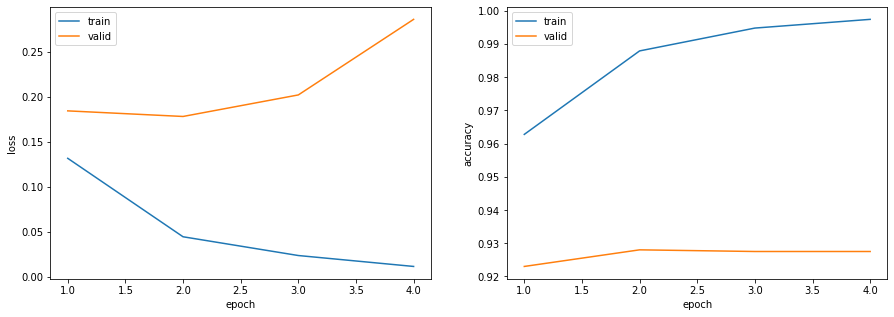

In [11]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [12]:
# 正解率の算出
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

print(
    f'正解率（学習データ）：{calculate_loss_and_accuracy(model, dataloader_train, device)[1]:.3f}')
print(
    f'正解率（検証データ）：{calculate_loss_and_accuracy(model, dataloader_valid, device)[1]:.3f}')
print(
    f'正解率（評価データ）：{calculate_loss_and_accuracy(model, dataloader_test, device)[1]:.3f}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


ストリーミング出力は最後の 5000 行に切り捨てられました。
          0.8177,  0.6839,  0.5685,  0.6299,  0.6434, -0.6032,  0.1759,  0.5905,
         -0.3034, -0.5276,  0.4214,  0.8777, -0.4153, -0.7418, -0.1476,  0.0303,
         -0.9973,  0.2807,  0.1822,  0.6749, -0.7809, -0.5299, -0.8828,  0.5568,
         -0.4649, -0.5359,  0.4377,  0.5765,  0.9997, -0.6785, -0.3027,  0.1087,
         -0.8606,  0.3170,  0.0531, -0.4798,  0.2759,  0.9409, -0.7018,  0.8127,
         -0.6400, -0.8847,  0.8979,  0.2766, -0.8323, -0.2788, -0.2897,  0.5237,
          0.4823, -0.7487,  0.9542,  0.7524,  0.6937, -0.3875, -0.2533,  0.7637,
         -0.4999,  0.6689,  0.3369,  0.0659,  0.8544, -0.1949, -0.7651, -0.1366,
          0.5992, -0.8287,  0.2072,  0.7567, -0.9085,  0.7680,  0.2551,  0.9931,
         -0.9949,  0.4029, -0.1033,  0.9801, -0.4313, -0.0705,  0.8150,  0.7534,
         -0.4852, -0.6457, -0.6981, -0.8072, -0.7554,  0.9920,  0.9936,  0.5597,
          0.3993, -0.6413,  0.9200,  0.6077, -0.6540,  0.8622,  0.9615,  0.67